In [92]:
# project 2, Group 7

In [93]:
# task 1

In [94]:
class OptimizationProblem:
    def __init__(self, f, grad=None):
        self.f = f
        self.grad = grad

    def evaluate(self, x):
        return float(self.f(x))

    def gradient(self, x):
        if self.grad is None:
            raise NotImplementedError("No gradient provided.")
        return np.array(self.grad(x), dtype=float)

In [95]:
# task 2: general opitimization class

In [102]:
class OptimizationMethod:
    def __init__(self, problem, tol=1e-6, max_iter=100):
        self.problem = problem
        self.tol = tol
        self.max_iter = max_iter
        self.history = []

    def compute_direction(self, x):
        # need implemention
        raise NotImplementedError

    def line_search(self, x, s, g):
        alpha = 1.0  # will be changed in the subsequet tasks 
        return alpha

    def solve(self, x0):
        x = np.array(x0, dtype=float)
        self.history.append(x.copy()) # record the history for task5
        for _ in range(self.max_iter):
            g = self.problem.gradient(x)
            if np.linalg.norm(g) < self.tol:
                break
            s = self.compute_direction(x, g)
            alpha = self.line_search(x, s, g)
            x = x + alpha * s
            self.history.append(x.copy()) # record the history for task5
        return x


使用newton method来测试[task1，task2]，可以参考

In [97]:
import numpy as np
from chebyquad_problem import chebyquad, gradchebyquad

#newton method
def fd_hessian(f, x, eps=1e-6):
    n = x.size
    H = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i] = 1.0
        for j in range(i, n):
            ej = np.zeros(n); ej[j] = 1.0
            if i == j:
                H[i, i] = (f(x+eps*ei) - 2*fx + f(x-eps*ei)) / (eps**2)
            else:
                fpp = f(x + eps*ei + eps*ej)
                fpm = f(x + eps*ei - eps*ej)
                fmp = f(x - eps*ei + eps*ej)
                fmm = f(x - eps*ei - eps*ej)
                H[i, j] = H[j, i] = (fpp - fpm - fmp + fmm) / (4*eps**2)
    # 对称化（Task3 要求 G := 0.5*(G + G^T)）
    return 0.5*(H + H.T)

class NewtonMethod(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        # 解 H s = -g
        return -np.linalg.solve(H, g)

    # 可选：以后你可以在 Task4 替换为 exact line search
    # def line_search(self, x, s, g): ...
for n in (4, 8, 11):
    x0 = np.linspace(0, 1, n)  # 题目里常用的初始点
    prob = OptimizationProblem(chebyquad, gradchebyquad)
    x_star = NewtonMethod(prob, tol=1e-8, max_iter=200).solve(x0)
    print(f"n={n}, x*=", np.round(x_star, 6), " f(x*)=", prob.evaluate(x_star))

n=4, x*= [0.112702 0.3709   0.6291   0.887298]  f(x*)= 1.2518544638517033e-32
n=8, x*= [0.051472 0.199429 0.308722 0.427707 0.572293 0.691278 0.800571 0.948528]  f(x*)= 1.230219073058731e-18
n=11, x*= [0.12337  0.23721  0.415016 0.014156 0.014156 0.014156 0.014156 0.663733
 0.663733 0.863794 0.973254]  f(x*)= 0.49239111387491263


In [ ]:
#task 3
import numpy as np

def fd_hessian(f, x, eps=1e-6):
    n = x.size
    H = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i] = 1.0
        for j in range(i, n):
            ej = np.zeros(n); ej[j] = 1.0
            if i == j:
                H[i, i] = (f(x + eps * ei) - 2 * fx + f(x - eps * ei)) / eps**2
            else:
                fpp = f(x + eps * ei + eps * ej)
                fpm = f(x + eps * ei - eps * ej)
                fmp = f(x - eps * ei + eps * ej)
                fmm = f(x - eps * ei - eps * ej)
                H[i, j] = H[j, i] = (fpp - fpm - fmp + fmm) / (4 * eps**2)
    return 0.5 * (H + H.T)

class NewtonMethod(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        return -np.linalg.solve(H, g)

In [104]:
# task 4
from scipy.optimize import minimize_scalar

class NewtonMethodExactLineSearch(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        return -np.linalg.solve(H, g)

    def line_search(self, x, s, g):
        phi = lambda alpha: self.problem.evaluate(x + alpha * s)
        res = minimize_scalar(phi, bounds=(0, 1), method='bounded')
        return res.x

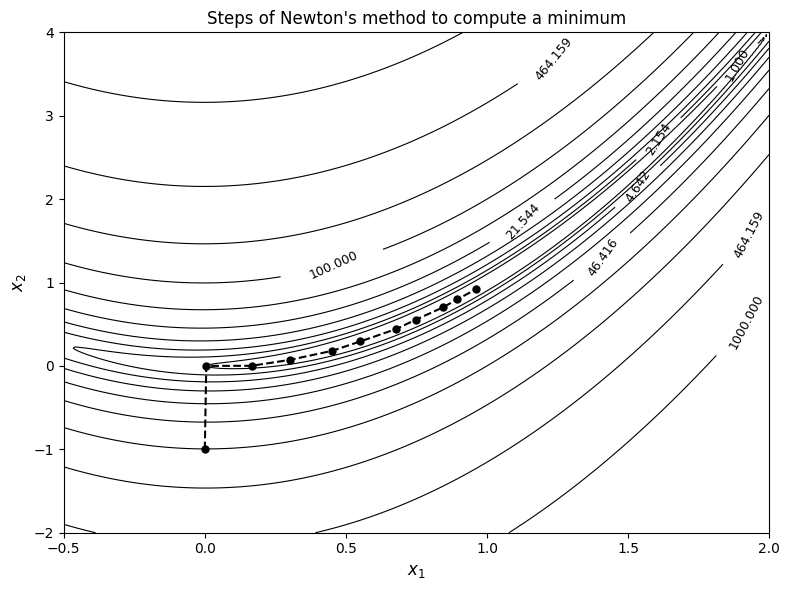

In [113]:
#task 5
import matplotlib.pyplot as plt
import numpy as np

# Define Rosenbrock function and its gradient
def rosenbrock_f(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosenbrock_grad(x):
    df_dx0 = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    df_dx1 = 200 * (x[1] - x[0]**2)
    return np.array([df_dx0, df_dx1])

problem = OptimizationProblem(f=rosenbrock_f, grad=rosenbrock_grad)
optimizer = NewtonMethodExactLineSearch(problem, max_iter=10)
x0 = np.array([0.0, -1.0])
xmin = optimizer.solve(x0)
trajectory = np.vstack(optimizer.history)

x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-2, 4, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = 100 * (Y - X**2)**2 + (1 - X)**2

plt.figure(figsize=(8, 6))

levels = np.logspace(0, 3, 10) # 从1到1000的对数分布
CS = plt.contour(X, Y, Z, levels=levels, colors='black', linewidths=0.8)
plt.clabel(CS, inline=True, fontsize=9, fmt="%.3f")


plt.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=1.5)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ko', markersize=5)

plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title("Steps of Newton's method to compute a minimum", fontsize=12)
plt.xlim([-0.5, 2.0])
plt.ylim([-2.0, 4.0])
plt.grid(False)
plt.tight_layout()
plt.show()
